In [3]:
import os
def Count_files_in_subd():
    l = []
    counter=0
    for root, dirs, files in os.walk("download_landsat_images/"):
        # print("{} in {}".format(len(files), root))
        l.append(len(files))
        for f in files:
            if f == 'least_cloudy_clipped_highres.tif':
                counter+=1
        if len(files) == 0:
            print(root)
    al = len(os.listdir("download_landsat_images/"))
    print(f'Num folders total: {al}')
    print(f'Num folders with 0 files: {l.count(0)}')
    print(f'Num folders with >0 files: {al - l.count(0)}')
    print(f'Num target files total: {counter}')
    print()
    
Count_files_in_subd()

download_landsat_images/
download_landsat_images/.ipynb_checkpoints
download_landsat_images/36031961400
download_landsat_images/36009961301
download_landsat_images/36025971300
download_landsat_images/36103990100
Num folders total: 8232
Num folders with 0 files: 6
Num folders with >0 files: 8226
Num target files total: 8223



In [4]:
def get_img(geoid):
    feat = tracts.filter(ee.Filter.eq('GEOID', geoid)).first()
    roi = feat.geometry()

    collection = (
      ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')  # https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1
      .filterBounds(roi)
      .filter(ee.Filter.contains('.geo', roi))
      .filterDate('2020-01-01', '2023-01-01')
      .sort('CLOUD_COVER')
    )
    top = collection.limit(10)

    # take the median pixel value; clip to the census geometry 
    # composite = top.median().clip(roi)
    img = top.first().clip(roi)
    return img#, geoid

In [5]:
import os
import ee
import geemap
import matplotlib.pyplot as plt

In [39]:
import ee
# ee.Authenticate()
ee.Initialize()

In [19]:
import geopandas as gpd
import pandas as pd
tract_data_dir = r'../Tracts/nyc_metro_boundaries/nyc_metro_boundaries.shp'
temp_tract_data_dir = "../Tracts/nyc_metro_boundaries/test.shp"

df = gpd.read_file(tract_data_dir)
df.rename(columns={'GEOID_TRAC': 'GEOID'}, inplace=True)  
# print(df.head())
shapefile = df[['GEOID', 'geometry']] 
# shapefile.iloc[0:20].to_file(temp_tract_data_dir)

In [20]:
shapefile.loc[shapefile.GEOID == '36103170206'].to_file(temp_tract_data_dir)

In [21]:
tracts = geemap.shp_to_ee(temp_tract_data_dir)

In [35]:
geoid = '36103170206'

# feat = tracts.filter(ee.Filter.eq('GEOID', geoid)).first()
# roi = feat.bounds().geometry()

save_dir = 'download_landsat_images'
subdir = f"{save_dir}/{geoid}"
filename = f"{subdir}/least_cloudy_clipped_highres.tif"
if os.path.exists(filename):
    print(f'continue: {filename}')
    
# init_dir(subdir)
img = get_img(geoid)

img = img.select(['B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7'])
geemap.ee_export_image(
        img, filename=filename, file_per_band=True)

continue: download_landsat_images/36103170206/least_cloudy_clipped_highres.tif


NameError: name 'tracts' is not defined

In [12]:
geoid = tracts.first().get('GEOID')

In [13]:
feat = tracts.filter(ee.Filter.eq('GEOID', geoid)).first()
roi = feat.geometry()

In [16]:
images = get_img(geoid)

In [17]:
images

In [59]:
# l = images.toList(10)
# for i in range(0, 10):
#     info = l.get(i).getInfo()
#     print(info['bands'][0])

In [56]:
# images.first().getInfo()['bands'][0]

In [57]:
# composite.getInfo()['bands'][0]  # the median image, clipped

In [58]:
# first.getInfo()  # just the first image, clipped

In [131]:
proj = ee.Projection('EPSG:32618')

In [137]:
filename = 'download_test/'

composite = images.reduce(ee.Reducer.median())#.reproject(proj)#.clip(roi)
first = images.first()#.clip(roi)

In [133]:
first.getInfo()['bands'][0]

{'id': 'B1',
 'data_type': {'type': 'PixelType', 'precision': 'float'},
 'dimensions': [7641, 7771],
 'crs': 'EPSG:32618',
 'crs_transform': [30, 0, 560985, 0, -30, 4741215]}

In [126]:
geemap.ee_export_image(
                first, filename='download_test/ct1.tif', scale=90, region=roi, file_per_band=False
            )
    
geemap.ee_export_image(
            composite, filename='download_test/ct2.tif', scale=90, region=roi, file_per_band=False
        )

Generating URL ...
Please wait ...
Data downloaded to /home/juro4948/region_representation_learning/regional-representations-graph-model/dataset/earth_engine/download_test/ct1.tif
Generating URL ...
Please wait ...
An error occurred while downloading.


In [127]:
# plot all
Map = geemap.Map()
Map.setCenter(-74.0060, 40.7128, 8)
visParams = {'bands': ['B6_median'], 'min': 0, 'max': 0.2}
Map.addLayer(composite.clip(roi), visParams, 'Landsat8')
Map

Map(center=[40.7128, -74.006], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [128]:
# plot all
Map = geemap.Map()
Map.setCenter(-74.0060, 40.7128, 8)
visParams = {'bands': ['B6'], 'min': 0, 'max': 0.2}
Map.addLayer(first.clip(roi), visParams, 'Landsat8')
Map

Map(center=[40.7128, -74.006], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

# READ IMAGES


In [6]:
import numpy as np
import pandas as pd
import imageio.v2 as imageio

In [7]:
import skimage

In [8]:
def norm(band):
    band_min, band_max = np.nanmin(band), np.nanmax(band)
    return ((band - band_min)/(band_max - band_min))

In [51]:
def make_color_image_eqh(
    b1, b2, b3, 
):
   
    eq_b1 = skimage.exposure.equalize_hist(b1, mask=(~np.isnan(b1)))
    eq_b2 = skimage.exposure.equalize_hist(b2, mask=(~np.isnan(b2)))
    eq_b3 = skimage.exposure.equalize_hist(b3, mask=(~np.isnan(b3)))

    # normalize data to 0<->1
    b1_norm = norm(eq_b1)
    b2_norm = norm(eq_b2)
    b3_norm = norm(eq_b3)

    # create three color image
#     rgb = np.stack([b1_norm, b2_norm, b3_norm], axis=2)
    
    
    rgb = np.dstack((b1_norm, b2_norm, b3_norm))

    return rgb

def equalize_exposure(b1, b2, b3):
    eq_b1 = skimage.exposure.equalize_hist(b1, mask=(~np.isnan(b1)))
    eq_b2 = skimage.exposure.equalize_hist(b2, mask=(~np.isnan(b2)))
    eq_b3 = skimage.exposure.equalize_hist(b3, mask=(~np.isnan(b3)))
    
    rgb = np.dstack((eq_b1, eq_b2, eq_b3))

    return rgb

(261, 205, 3)


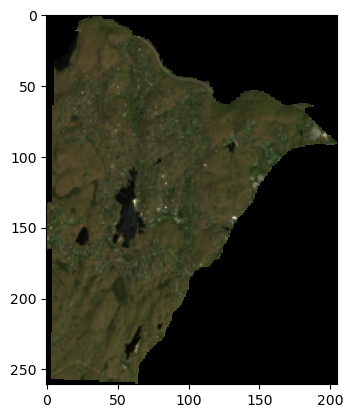

In [6]:
import imageio.v2 as imageio
img = imageio.imread(f'download_landsat_images/34027040702/least_cloudy_clipped_highres.tif')
B2_blue = img[:,:,1]
B3_green = img[:,:,2]
B4_red = img[:,:,3]


rgb = np.stack([B4_red, B3_green, B2_blue])
# mod = rgb.reshape(rgb.shape[1], rgb.shape[2], 3)
mod = rgb.transpose(1, 2, 0)
mod[mod == -np.inf] = np.nan

# normalize
mod1 = np.zeros(mod.shape)
# mod2 = np.zeros(mod.shape)
for band in (0,1,2):
#     mod1[:,:,band] = ss.fit_transform(mod[:,:,band])
#     mod2[:,:,band] = mm.fit_transform(mod[:,:,band])
    mod1[:,:,band] = norm(mod[:,:,band])

print(mod.shape)
plt.figure()
plt.imshow(mod1)
# plt.figure()
# plt.imshow(mod2)

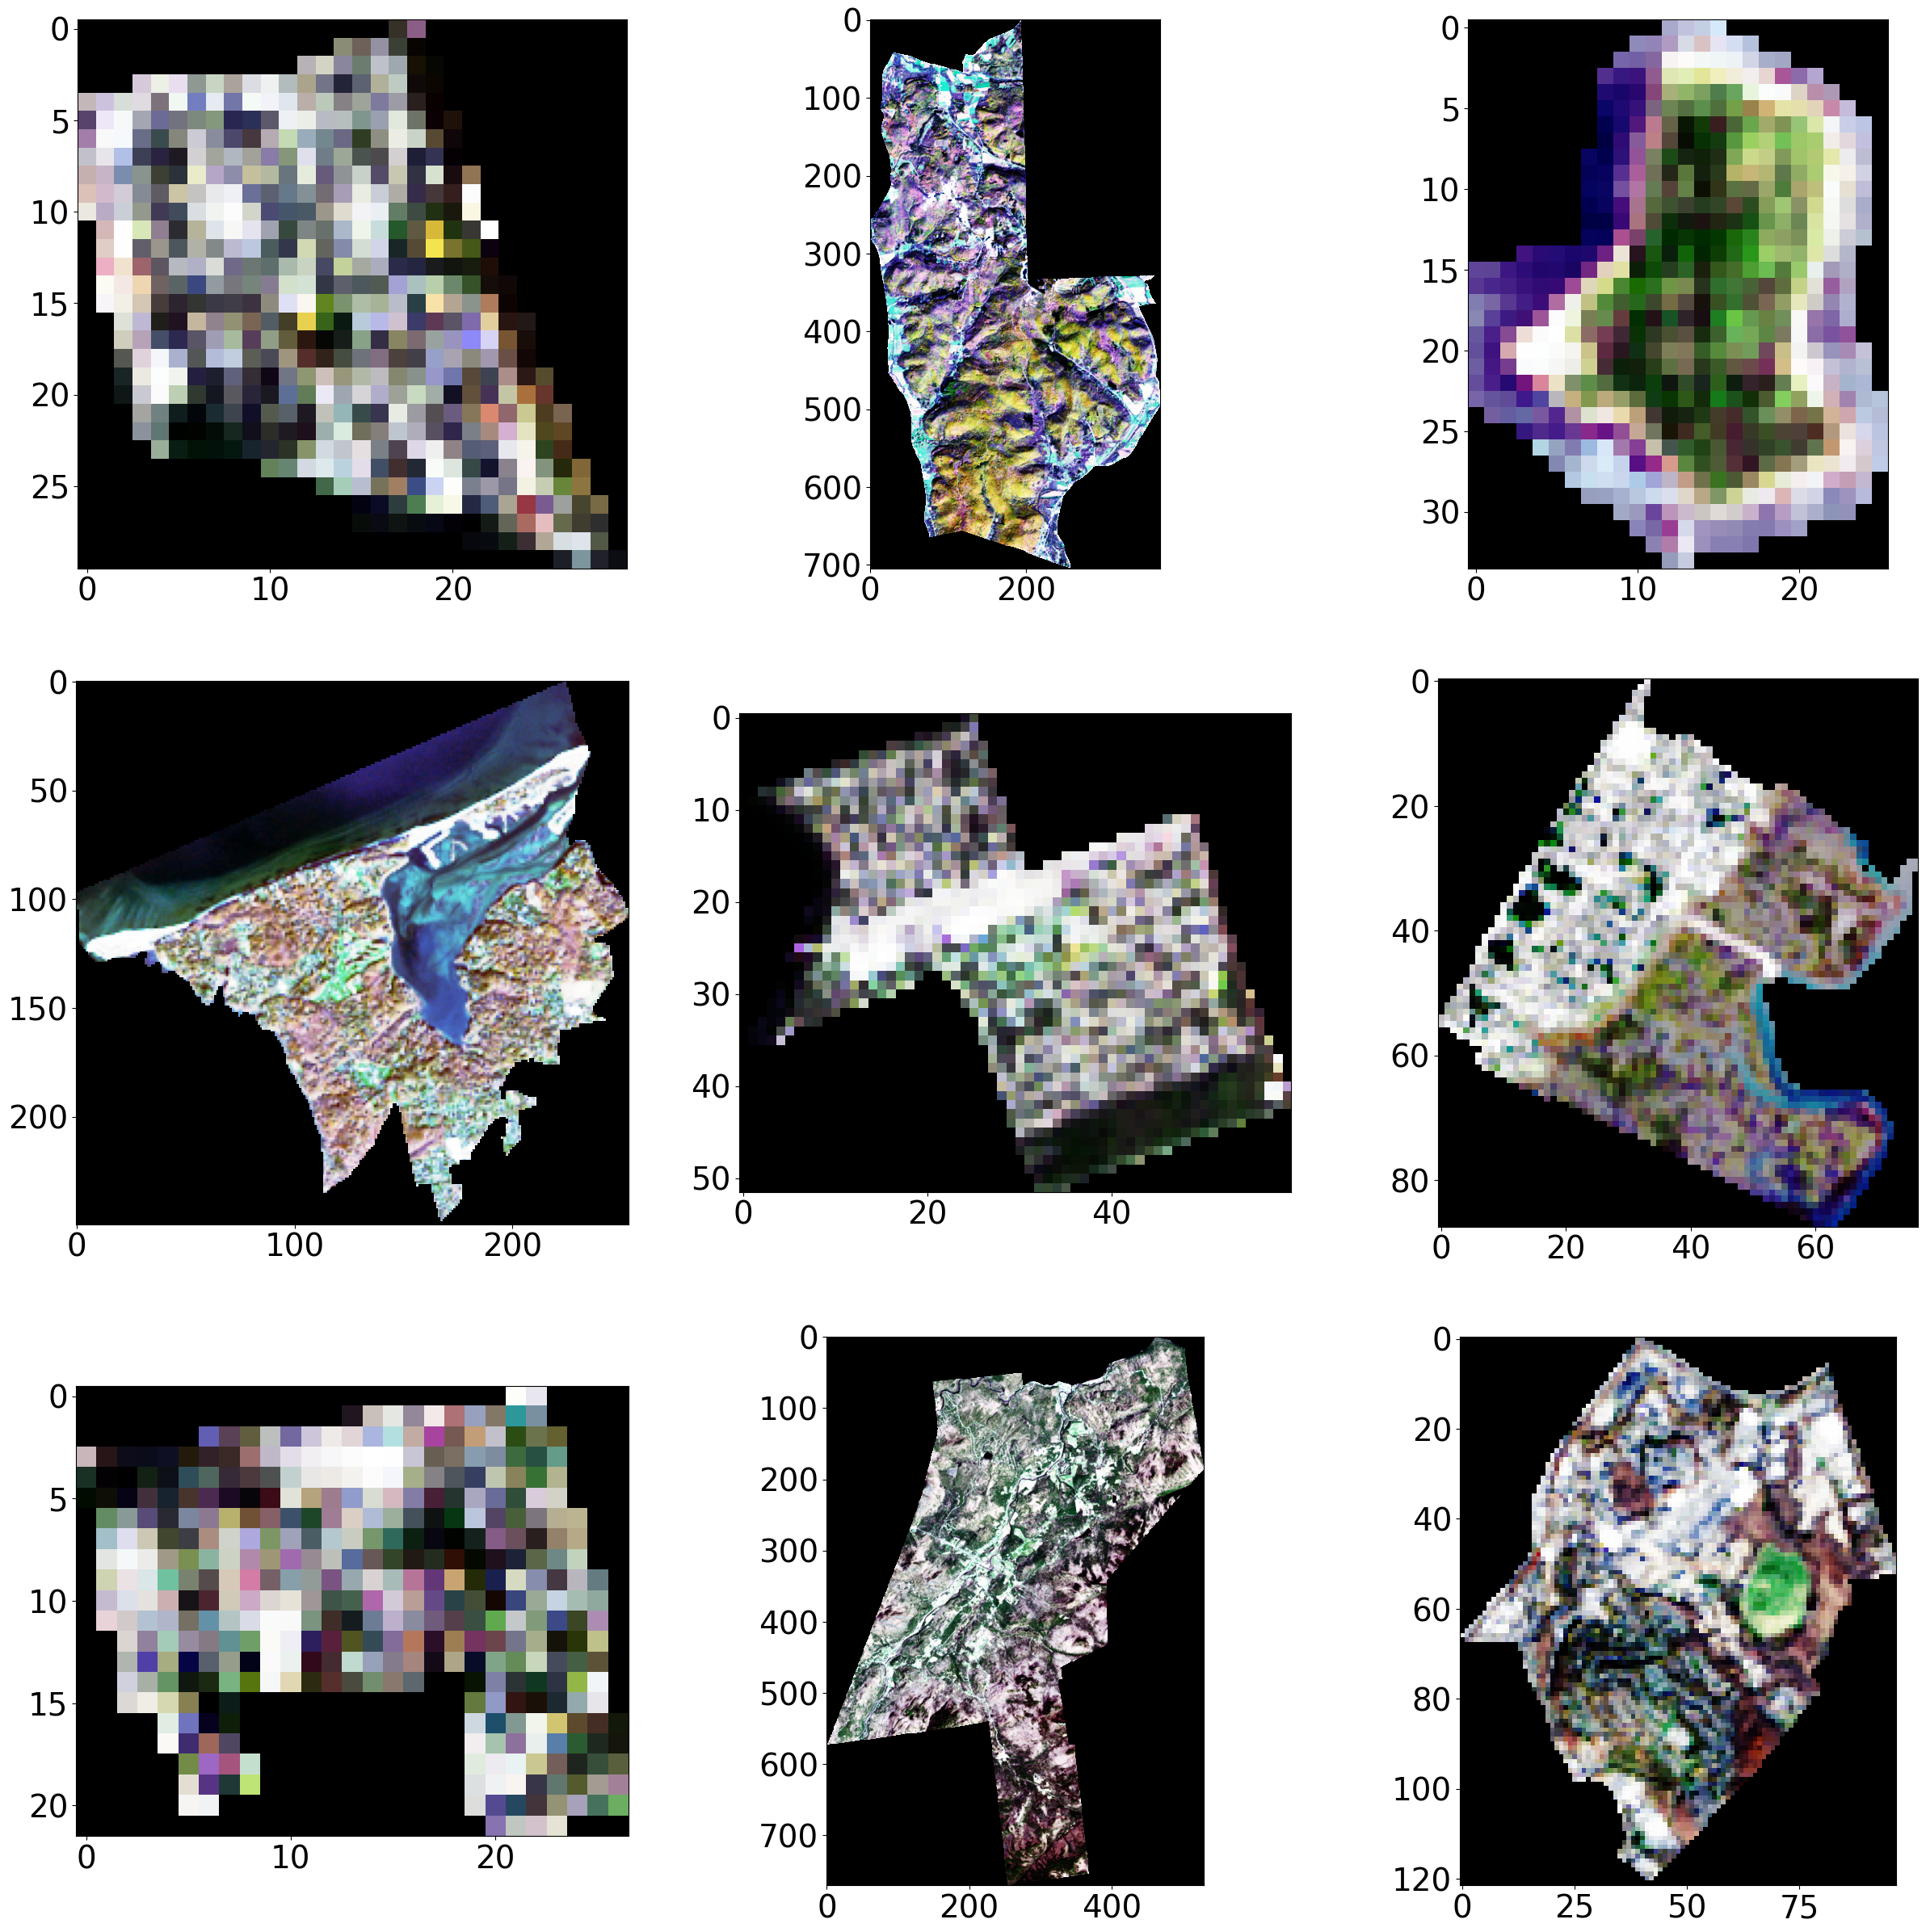

In [41]:
import random
plt.rcParams.update({'font.size': 28})
r, c = 3, 3

dirs = [x[0] for x in os.walk('download_landsat_images/')]
fig, axs = plt.subplots(r, c, figsize=(30, 30))
for i in range(r):
    for j in range(c):
        select = random.choice(dirs)
        img = imageio.imread(f'{select}/least_cloudy_clipped_highres.tif')
    
        B2_blue = img[:,:,1]
        B3_green = img[:,:,2]
        B4_red = img[:,:,3]
        
        rgb = np.stack([B4_red, B3_green, B2_blue])
        mod = rgb.transpose(1, 2, 0)
        mod[mod == -np.inf] = np.nan

#         # normalize
#         mod1 = np.zeros(mod.shape)
#         mod2 = np.zeros(mod.shape)
#         for band in (0,1,2):
#             mod1[:,:,band] = norm(mod[:,:,band])
        
        mod1 = make_color_image_eqh(mod[:,:,0], mod[:,:,1], mod[:,:,2])
        axs[i][j].imshow((mod1))

In [8]:
print(f'Max: {np.nanmax(mod)}')
print(f'Min: {np.nanmin(mod)}')

print(f'Max: {np.nanmax(mod1)}')
print(f'Min: {np.nanmin(mod1)}')

Max: 0.6127372980117798
Min: 0.036960139870643616
Max: 1.0
Min: 0.0


In [65]:
import torch
import torchvision

transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])


# Plot original vs transformed

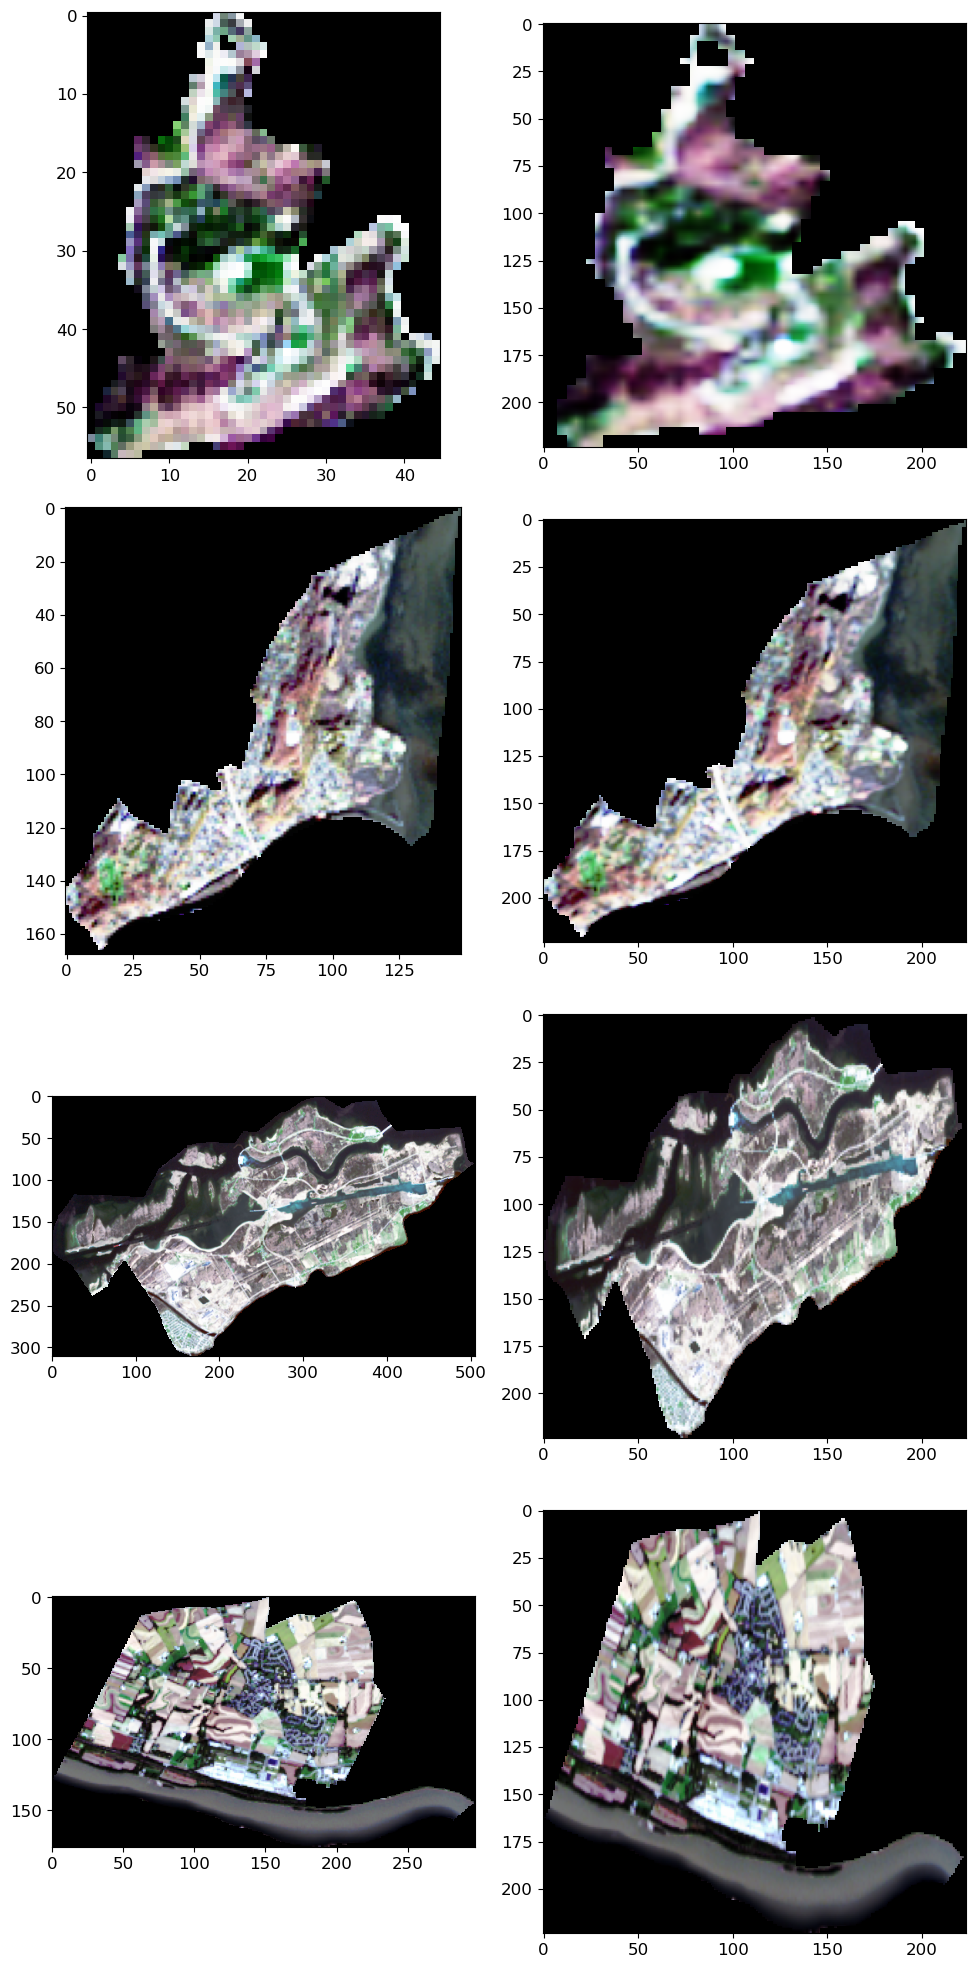

In [64]:
import random
plt.rcParams.update({'font.size': 12})
r, c = 4, 2

dirs = [x[0] for x in os.walk('download_landsat_images/')]
fig, axs = plt.subplots(r, c, figsize=(10, 20))
fig.tight_layout()
for i in range(r):
    select = random.choice(dirs)
    img = imageio.imread(f'{select}/least_cloudy_clipped_highres.tif')

 
    img = np.array(img)
    B1 = img[:,:,1]
    B2 = img[:,:,2]
    B3 = img[:,:,3]

    rgb = np.stack([B3, B2, B1], axis=0)
    

    # original
    rgb1 = rgb.transpose(1, 2, 0)
    rgb1[rgb1 == -np.inf] = np.nan
    rgb1[rgb1 == np.inf] = np.nan
    
#     print(rgb1.shape)
    mod1 = make_color_image_eqh(rgb1[:,:,0], rgb1[:,:,1], rgb1[:,:,2])
#     print(mod1.shape)
#     print('----')
    axs[i][0].imshow(mod1)
    
#     # transformed
    t = torch.tensor(rgb)
    out = np.array(transforms(t))
    out = out.transpose(1, 2, 0)
    out = equalize_exposure(out[:,:,0], out[:,:,1], out[:,:,2])
    
    
    axs[i][1].imshow(out)


#         mod[mod == -np.inf] = np.nan

#         # normalize
#         mod1 = np.zeros(mod.shape)
#         mod2 = np.zeros(mod.shape)
#         for band in (0,1,2):
#             mod1[:,:,band] = norm(mod[:,:,band])

#     mod1 = make_color_image_eqh(mod[:,:,0], mod[:,:,1], mod[:,:,2])
#     axs[i][j].imshow((mod1))

(22, 28, 17)
(22, 37, 17)
(22, 28, 17)
(22, 37, 17)


/tmp/ipykernel_165168/862300552.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(f'download_test/ct1.tif')
/tmp/ipykernel_165168/862300552.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(f'download_test/ct2.tif')
/tmp/ipykernel_165168/862300552.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img3 = imageio.imread(f'download_test

Text(0.5, 0.98, 'Band 2 (blue)')

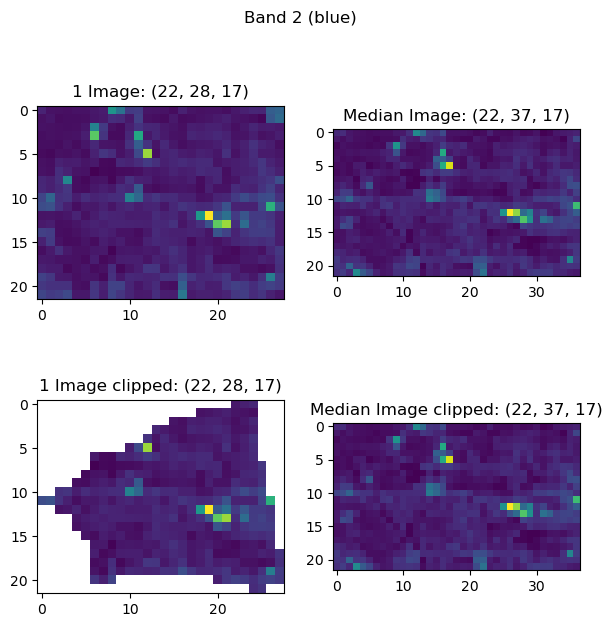

In [9]:
# Load images
import imageio
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

img1 = imageio.imread(f'download_test/ct1.tif')
img2 = imageio.imread(f'download_test/ct2.tif')
img3 = imageio.imread(f'download_test/ct1_clipped.tif')
img4 = imageio.imread(f'download_test/ct2_clipped.tif')

for ax, img, title in zip(axs.flatten(), [img1, img2, img3, img4], 
                          ['1 Image', 'Median Image', '1 Image clipped', 'Median Image clipped']):
    B2_blue = img[:,:,1]
    B3_green = img[:,:,2]
    B4_red = img[:,:,3]

    print(img.shape)
    ax.imshow(B2_blue)
    ax.set_title(f'{title}: {img.shape}')
plt.suptitle('Band 2 (blue)', fontsize=(12))